We want to determine what might influence how 'good' or 'bad' a given 
prediction is. 

Sample data below is from Alabama, location code '01'. 

The '1_week_roc' column denotes the percent change in new hospitalizations 
over 1 week. 

In [39]:
import numpy as np
import pandas as pd

df = pd.read_csv('hosp_roc_wis_test.csv')
df.head()

,Unnamed: 0,date,1wk_WIS,2wk_WIS,3wk_WIS,4wk_WIS,prev_week_hosp,1_week_roc,2_week_roc
0,0,2023-10-14,9.79,11.85,16.83,31.85,26.0,0.300000,0.130435
1,1,2023-10-21,6.39,9.17,26.23,46.71,30.0,0.153846,0.500000
2,2,2023-10-28,9.70,29.74,41.75,43.05,32.0,0.066667,0.230769
3,3,2023-11-04,22.23,36.92,27.09,40.09,37.0,0.156250,0.233333
4,4,2023-11-11,38.66,32.92,39.08,66.09,60.0,0.621622,0.875000


In [40]:
from sklearn import linear_model

X = df['1_week_roc'].values.reshape(-1, 1)
y = df['1wk_WIS'].values

reg = linear_model.LinearRegression()
model = reg.fit(X, y)
response = model.predict(X)

correlation = reg.coef_

<Axes: xlabel='1_week_roc', ylabel='1wk_WIS'>

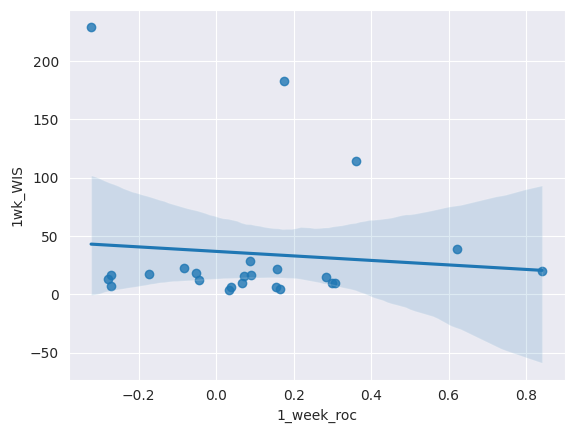

In [41]:
import seaborn as sns

sns.regplot(data = df, x = '1_week_roc', y = '1wk_WIS')

<Axes: xlabel='2_week_roc', ylabel='1wk_WIS'>

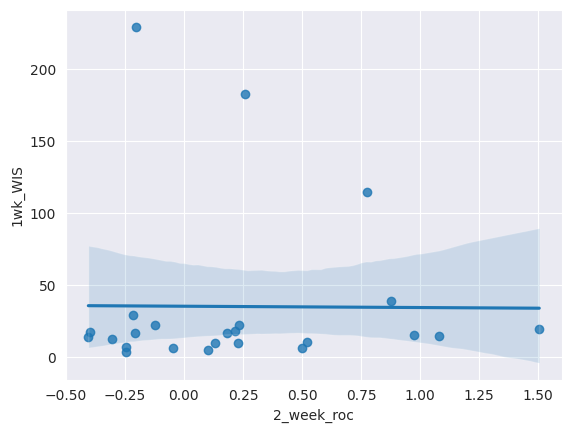

In [42]:
sns.regplot(data = df, x = '2_week_roc', y = '1wk_WIS')

Let's aggregate all data from all states and see if we find anything.

In [49]:
# Read location data.
locations = pd.read_csv("datasets/locations.csv").iloc[1:]  # skip first row (national ID)
# Map location codes to state abbreviations.

location_to_state = dict(zip(locations["location"], locations["abbreviation"]))


In [53]:
import pandas as pd
import numpy as np
import glob


def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['1wk_WIS', '2wk_WIS', '3wk_WIS', '4wk_WIS', '1_week_roc', '2_week_roc']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
print(aggregated_data.head())

   1wk_WIS  2wk_WIS  3wk_WIS  4wk_WIS  1_week_roc  2_week_roc
0     6.80    10.50    16.73    19.95    1.875000    0.769231
1    13.51    18.58    19.95    55.80    0.086957    2.125000
2    19.51    26.58    59.95    52.80    0.320000    0.434783
3     6.51    42.45    30.78    75.05    0.181818    0.560000
4    45.84    39.45    84.78    83.05    0.205128    0.424242


<Axes: xlabel='1_week_roc', ylabel='1wk_WIS'>

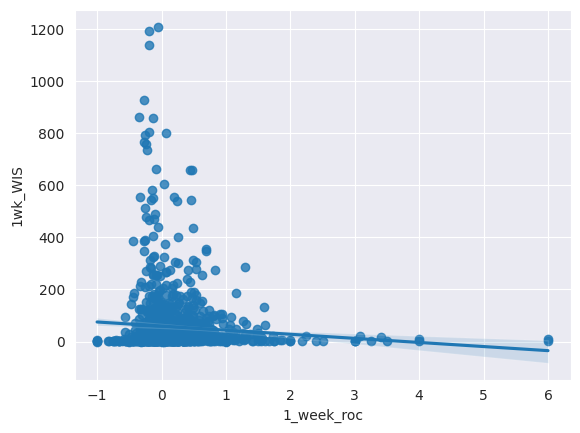

In [55]:
sns.regplot(data = aggregated_data, x = '1_week_roc', y = '1wk_WIS')

No correlation here, but I believe the direct correlation between population and WIS score might be playing a role in the lack of correlation. 

So, I am going to add a z_score to try and standardize the scores.

In [64]:
def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['1_week_roc', '2_week_roc', 'abs_z_1wk_WIS', 'abs_z_2wk_WIS', 'abs_z_3wk_WIS', 'abs_z_4wk_WIS']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
print(aggregated_data.head())

   1_week_roc  2_week_roc  abs_z_1wk_WIS  abs_z_2wk_WIS  abs_z_3wk_WIS  \
0    1.875000    0.769231       1.126708       0.504031       0.544421   
1    0.086957    2.125000       0.692400       0.431399       0.360872   
2    0.320000    0.434783       1.026628       0.667308       1.028661   
3    0.181818    0.560000       1.129952       0.131733       0.277946   
4    0.205128    0.424242       0.727272       0.993744       0.896579   

   abs_z_4wk_WIS  
0       1.086318  
1       1.484671  
2       0.665275  
3       1.276166  
4       0.824436  


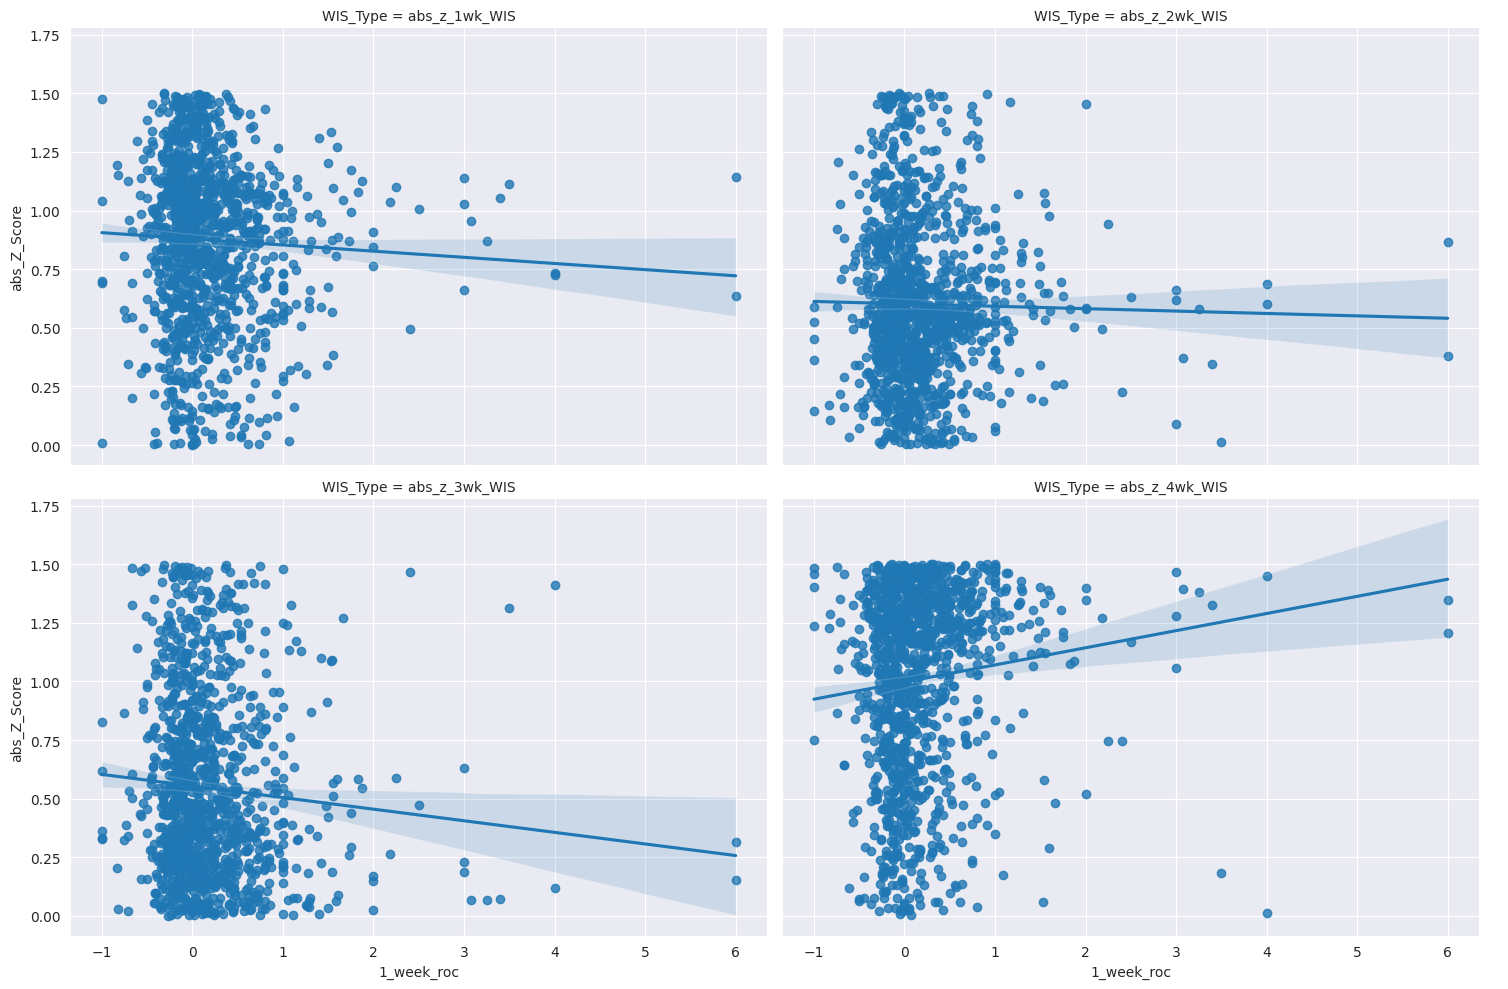

In [66]:
import matplotlib.pyplot as plt

melted_data = aggregated_data.melt(id_vars=['1_week_roc'], 
                                       value_vars=['abs_z_1wk_WIS', 'abs_z_2wk_WIS', 'abs_z_3wk_WIS', 'abs_z_4wk_WIS'], 
                                       var_name='WIS_Type', value_name='abs_Z_Score')

g = sns.FacetGrid(melted_data, col='WIS_Type', col_wrap=2, height=5, aspect=1.5)
g.map(sns.regplot, '1_week_roc', 'abs_Z_Score')
g.add_legend()
plt.show()

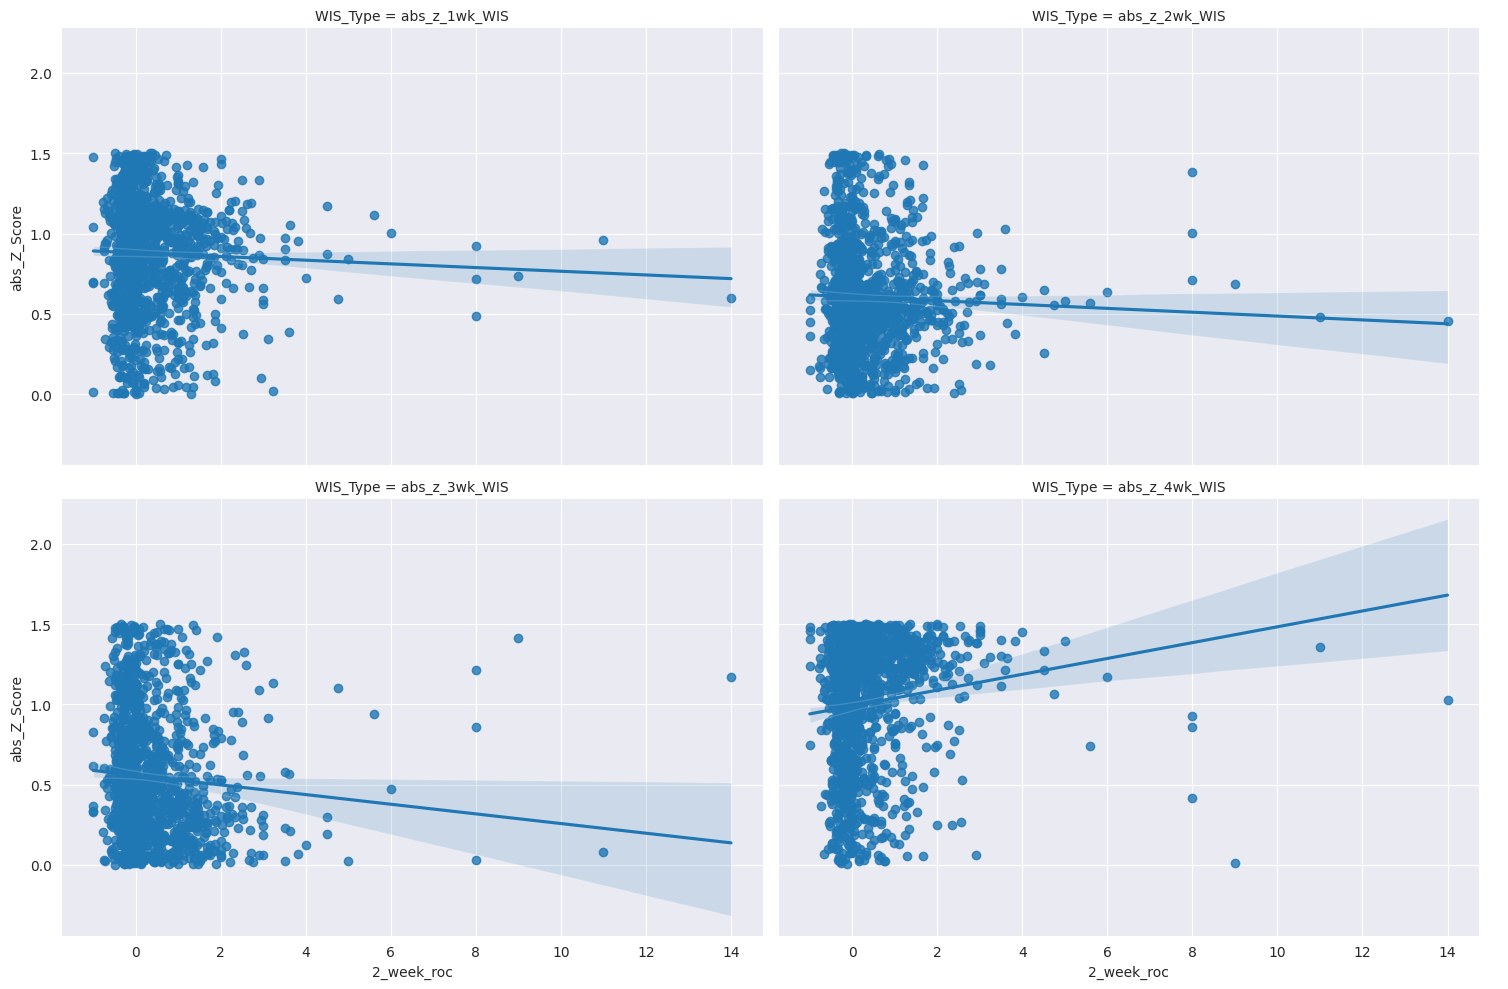

In [67]:
melted_data = aggregated_data.melt(id_vars=['2_week_roc'], 
                                       value_vars=['abs_z_1wk_WIS', 'abs_z_2wk_WIS', 'abs_z_3wk_WIS', 'abs_z_4wk_WIS'], 
                                       var_name='WIS_Type', value_name='abs_Z_Score')

g = sns.FacetGrid(melted_data, col='WIS_Type', col_wrap=2, height=5, aspect=1.5)
g.map(sns.regplot, '2_week_roc', 'abs_Z_Score')
g.add_legend()
plt.show()